In [1]:
%load_ext autoreload
%autoreload 2

from cnn import CNN
from dyn_cnn import DynCNN
from util import Util
from patch import Patch
from fixer import Fixer
from uglify import Uglify

import os
import mahotas as mh
import numpy as np
import time

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, CuDNN 4007)
/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
tifffile.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)
/home/d/nolearn/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#
# viren's approach with our LARGER border_overlap
#   image prob merged_array dyn_obj dyn_bnd border_overlap
networks = []
networks.append(CNN('viren_7', 'patches_7th', ['image', 'prob', 'merged_array']))
# networks.append(CNN('mine_7', 'patches_7th', ['image', 'prob', 'binary', 'border_overlap']))
# networks.append(CNN('mine_large_7', 'patches_7th', ['image', 'prob', 'binary', 'larger_border_overlap']))
networks.append(CNN('mine_merged_7', 'patches_7th', ['image', 'prob', 'merged_array', 'border_overlap']))
networks.append(CNN('mine_merged_large_7', 'patches_7th', ['image', 'prob', 'merged_array', 'larger_border_overlap']))
# networks.append(DynCNN('dyn_viren_7', 'patches_7th', ['image', 'prob', 'merged_array']))
# networks.append(DynCNN('dyn_mine_7', 'patches_7th', ['image', 'prob', 'binary', 'border_overlap']))
# networks.append(DynCNN('dyn_mine_large_7', 'patches_7th', ['image', 'prob', 'binary', 'larger_border_overlap']))
# networks.append(DynCNN('dyn_mine_merged_7', 'patches_7th', ['image', 'prob', 'merged_array', 'border_overlap']))
# networks.append(DynCNN('dyn_mine_merged_large_7', 'patches_7th', ['image', 'prob', 'merged_array', 'larger_border_overlap']))


Loading ['/home/d/dojo_xp/nets/viren_7/configuration.txt']
Loading /home/d/dojo_xp/nets/viren_7/network_350.p
Loading ['/home/d/dojo_xp/nets/mine_merged_7/configuration.txt']
Loading /home/d/dojo_xp/nets/mine_merged_7/network_251.p
Loading ['/home/d/dojo_xp/nets/mine_merged_large_7/configuration.txt']
Loading /home/d/dojo_xp/nets/mine_merged_large_7/network_262.p


In [4]:
input_image, input_prob, input_gold, input_rhoana, dojo_bbox = Util.read_dojo_data() 

In [5]:
DOJO_USER_DATA_FOLDER = '/home/d/Dropbox/DOJOSTUDY/'
DOJO_USERS_IDS = [11,13,18,37,40,43,5,50,53,62]
DOJO_USERS = []
for d in DOJO_USERS_IDS:
    DOJO_USERS.append('S'+str(d)+'tif')
    
def read_user(user, slice):
    img = mh.imread(DOJO_USER_DATA_FOLDER+user+os.sep+'z='+str(slice).zfill(8)+'.tif')
    img = Util.crop_by_bbox(img, dojo_bbox)
    return Util.frame_image(img)

def dojo_user_vi(user, slice, gt):
    img = read_user(user, slice)
    return Util.vi(img, gt)

def fix_dojo_slice(cnn, slice, input_image, input_prob, input_rhoana, input_gold,t=0.):
    DOJO_SLICE=slice
    vi_s, merge_pairs, surenesses = Fixer.splits(cnn, 
                                                 input_image[DOJO_SLICE], 
                                                 input_prob[DOJO_SLICE], 
                                                 input_rhoana[DOJO_SLICE], 
                                                 input_gold[DOJO_SLICE],
                                                 sureness_threshold=t,
                                                 oversampling=False)

    best_index = vi_s.index(np.min(vi_s))
    best_vi = vi_s[best_index]
    best_sureness = surenesses[best_index]
    
    return best_vi, best_sureness, vi_s, surenesses

def fix_dojo_slice_user_simulated(cnn, slice, input_image, input_prob, input_rhoana, input_gold, error_rate=0,t=0):
    DOJO_SLICE=slice
    vi_s, merge_pairs, surenesses, good_fixes, bad_fixes = Fixer.splits_user_simulated(cnn, 
                                                 input_image[DOJO_SLICE], 
                                                 input_prob[DOJO_SLICE], 
                                                 input_rhoana[DOJO_SLICE], 
                                                 input_gold[DOJO_SLICE],
                                                 error_rate=error_rate,
                                                 sureness_threshold=t,                                                 
                                                 oversampling=False)
    
    best_index = vi_s.index(np.min(vi_s))
    best_vi = vi_s[best_index]
    best_sureness = surenesses[best_index]
    
    return best_vi, good_fixes, bad_fixes, merge_pairs, vi_s

def threed_vi(gt, seg):
    total_vi = 0
    slice_vi = []    
    for i in range(10):
        current_vi = Util.vi(gt[i].astype(np.int64), seg[i].astype(np.int64))
        total_vi += current_vi
        slice_vi.append(current_vi)
    total_vi /= 10
    return total_vi, slice_vi

def user_threed_vi(gt, user):
    total_vi = 0
    slice_vi = []
    for i in range(10):
        current_vi = dojo_user_vi(user, i, gt[i])
        total_vi += current_vi
        slice_vi.append(current_vi)
    total_vi /= 10
    return total_vi, slice_vi
    
def cnn_threed_vi(cnn, input_image, input_prob, input_rhoana, input_gold):
    total_vi = 0
    slice_vi = []
    slice_sureness = []
    for i in range(10):
        current_vi, sureness = fix_dojo_slice(cnn, i, input_image, input_prob, input_rhoana, input_gold)
        total_vi += current_vi
        slice_vi.append(current_vi)
        slice_sureness.append(sureness)
    total_vi /= 10
    return total_vi, slice_vi, slice_sureness
        

In [6]:
threed_vi(input_gold, input_rhoana)

(0.5145696221706644,
 [0.4564952264711417,
  0.4293922557471461,
  0.41812625771753,
  0.4176715560855522,
  0.49071969954324857,
  0.46200276923857864,
  0.5851840840738847,
  0.6340148263120815,
  0.6552543410401137,
  0.5968352054773662])

In [77]:
bigM, out, patches = Fixer.splits_global(networks[2], input_image, input_prob, input_rhoana, input_gold)

464 generated in 7.60894584656 seconds.
Grouped into 116 patches in 0.0021641254425 seconds.
448 generated in 9.04819417 seconds.
Grouped into 112 patches in 0.00200915336609 seconds.
456 generated in 9.20473504066 seconds.
Grouped into 113 patches in 0.0023090839386 seconds.
484 generated in 9.50823092461 seconds.
Grouped into 121 patches in 0.002366065979 seconds.
508 generated in 9.95910906792 seconds.
Grouped into 127 patches in 0.00231218338013 seconds.
488 generated in 9.64247512817 seconds.
Grouped into 122 patches in 0.00241994857788 seconds.
480 generated in 9.42580604553 seconds.
Grouped into 118 patches in 0.00252485275269 seconds.
460 generated in 9.08105683327 seconds.
Grouped into 113 patches in 0.00245714187622 seconds.
488 generated in 9.58530902863 seconds.
Grouped into 120 patches in 0.00236010551453 seconds.
540 generated in 10.7721099854 seconds.
Grouped into 135 patches in 0.00259208679199 seconds.


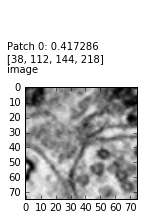

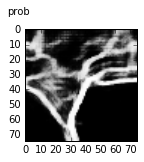

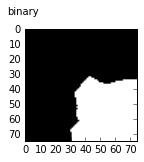

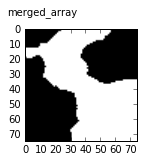

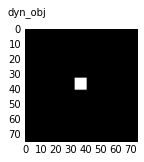

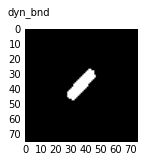

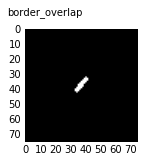

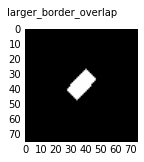

In [34]:
Patch.show(patches[0][0], networks[2], 0)

In [98]:
import cPickle as pickle
with open('/home/d/dojo_xp/data/bigM.p', 'wb') as f:
    pickle.dump(bigM, f)

In [58]:
flattened_patches = []
for z in range(0,10):
    for p in patches[z]:
        p['z'] = z
        flattened_patches.append(p)

In [96]:
bigM_max = -1
bigM_max_index = None
bigM_max_z = -1
for z,m in enumerate(bigM):
    if m.max() > bigM_max:
        bigM_max = m.max()
        bigM_max_indices = np.where(m == bigM_max)
        bigM_max_index = (bigM_max_indices[0][0], bigM_max_indices[1][0])
        bigM_max_z = z

In [97]:
bigM_max_index

(51, 57)

In [95]:
bigM[bigM_max_z][51,57]

0.99518775939941406

In [62]:
for p in flattened_patches:
    pred = networks[2].test_patch(p)
    p['prediction'] = pred

In [60]:
len(flattened_patches)

4816

In [66]:
sorted_flattened_patches = sorted(flattened_patches, key=lambda x: x['prediction'], reverse=True)

In [68]:
sorted_flattened_patches[0]

{'bbox': [285, 359, 131, 205],
 'binary': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], dtype=bool),
 'binary1': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], dtype=bool),
 'binary2': array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ..., 
        [Fal

In [69]:
with open('/home/d/dojo_xp/data/dojo_data_vis2014_patches_predicted.p', 'wb') as f:
    pickle.dump(sorted_flattened_patches, f)

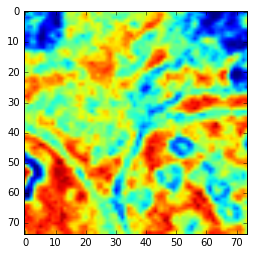

In [36]:
imshow(input_image[0][38:112,144:218])

In [27]:
threed_vi(input_gold, out)

(0.46831988319320567,
 [0.4050252609261369,
  0.4121594568115894,
  0.3918172770092099,
  0.4053514521002537,
  0.4337343707604937,
  0.41851464530707894,
  0.5240820744039167,
  0.5830389613197333,
  0.6172253790488904,
  0.4922499542447536])

In [16]:
all_splits = []
for m in bigM:
    all_splits.extend (np.tril(m).flatten())

In [18]:
max(all_splits)

0.93408244848251343

In [76]:
bigM[9].max()

0.93282866477966309

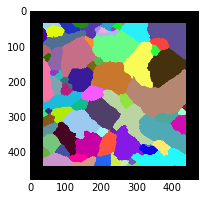

In [23]:
Util.view(out[0])

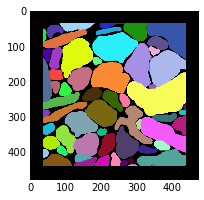

In [24]:
Util.view(input_gold[0])

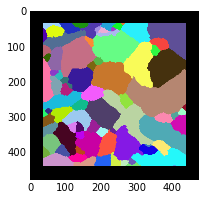

In [25]:
Util.view(input_rhoana[0])

In [201]:
cnn_vi_s = []
cnn_slice_vi_s = []
cnn_surenesses = []
cnn_times = []
for n in networks:
    t0 = time.time()
    cnn_vi, slice_vis, slice_sureness = cnn_threed_vi(n, input_image, input_prob, input_rhoana, input_gold)
    cnn_vi_s.append(cnn_vi)
    cnn_slice_vi_s.append(slice_vis)
    cnn_surenesses.append(slice_sureness)
    cnn_times.append(time.time()-t0)
    

464 generated in 10.1999530792 seconds.
Grouped into 116 patches in 0.00298094749451 seconds.
Merge loop finished in 20.2764430046 seconds.
Before VI: 0.456495226471
Smallest VI: 0.409136014296
Sureness threshold: 0.972009241581
448 generated in 9.58536195755 seconds.
Grouped into 112 patches in 0.00291514396667 seconds.
Merge loop finished in 25.6222200394 seconds.
Before VI: 0.429392255747
Smallest VI: 0.410100319075
Sureness threshold: 0.970213234425
456 generated in 9.93700003624 seconds.
Grouped into 113 patches in 0.00300097465515 seconds.
Merge loop finished in 21.2360320091 seconds.
Before VI: 0.418126257718
Smallest VI: 0.376229501303
Sureness threshold: 0.982782185078
484 generated in 10.1840078831 seconds.
Grouped into 121 patches in 0.00327706336975 seconds.
Merge loop finished in 24.1566948891 seconds.
Before VI: 0.417671556086
Smallest VI: 0.4053514521
Sureness threshold: 0.942233741283
508 generated in 10.6407830715 seconds.
Grouped into 127 patches in 0.00337409973145 s

In [271]:
np.mean(cnn_times)

369.01299064159394

In [267]:
np.mean(cnn_slice_vi_s[2])

0.49021509916746309

In [269]:
Util.stats(cnn_surenesses)

  N:  10
  Min:  0.67627286911
  Max:  0.998591244221
  Mean:  0.950593363643
  Median:  0.971555799246
  Std:  0.0614820470092
  Var:  0.00378004210444


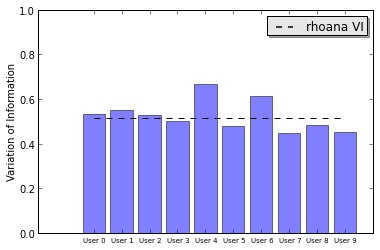

In [270]:

objects = []
performance = []
user_slice_vis = []
for i,d in enumerate(DOJO_USERS):
    objects.append('User '+ str(i))
    user_vi, slice_vis = user_threed_vi(input_gold, d)
    performance.append(user_vi)
    user_slice_vis.append(slice_vis)

before_vi, before_slice_vis = threed_vi(input_gold, input_rhoana)    

y_pos = np.arange(len(objects))    
    
fig, ax = plt.subplots()
ax.plot(range(0,10), [before_vi]*len(objects), 'k--', label='rhoana VI')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
ax.tick_params(axis='x', labelsize=7)
ax.set_ylim(0,1.)

plt.ylabel('Variation of Information')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width


In [204]:
performance[7]

0.44734259296152945

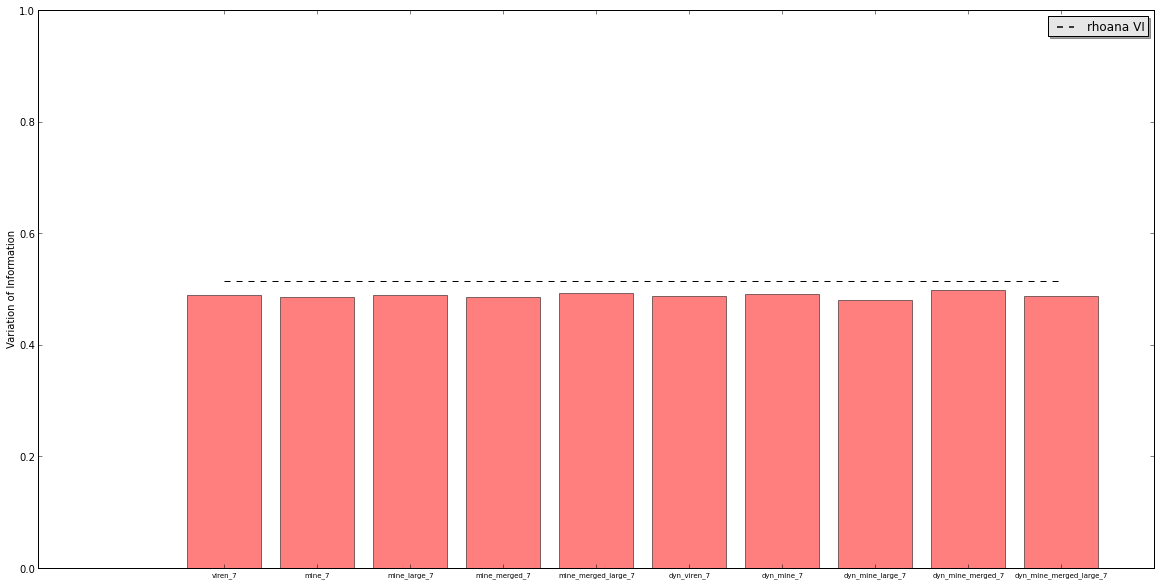

In [202]:
objects = []
performance = []
# user_slice_vis = []
for i,n in enumerate(networks):
    objects.append(n._NETWORK_ID)
#     user_vi, slice_vis = user_threed_vi(input_gold, d)
    performance.append(cnn_vi_s[i])
#     user_slice_vis.append(slice_vis)

before_vi, before_slice_vis = threed_vi(input_gold, input_rhoana)    

y_pos = np.arange(len(objects))    

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(range(0,10), [before_vi]*len(objects), 'k--', label='rhoana VI')
plt.bar(y_pos, performance, align='center', alpha=0.5, color='red')
plt.xticks(y_pos, objects)
ax.tick_params(axis='x', labelsize=7)
ax.set_ylim(0,1.)
plt.ylabel('Variation of Information')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

In [ ]:
simulated_user_er_vi_s =[]
for er in range(0,20,2):
    
    er = er/100.
    
    simulated_user_vi_s2 = []
    for i in range(0,10):
        best_vi, good_fixes, bad_fixes, merge_pairs, vi_s  = fix_dojo_slice_user_simulated(networks[7],i, input_image, input_prob, input_rhoana,input_gold, error_rate=er)
        simulated_user_vi_s2.append(vi_s[-1])

    simulated_user_er_vi_s.append(np.mean(simulated_user_vi_s2))

In [364]:
simulated_user_er_vi_s

[0.39430421016028483,
 1.1642547709997983,
 1.9709653273715642,
 2.7398125410710663,
 2.7035831007013966,
 3.0736174511057017,
 3.0984418028858625,
 3.1963695269804333,
 3.1723792784716798,
 3.1737815311698032]

In [360]:
best_vi, good_fixes, bad_fixes, merge_pairs, vi_s  = fix_dojo_slice_user_simulated(networks[7],0, input_image, input_prob, input_rhoana,input_gold, error_rate=.8, t=.95)

464 generated in 10.1940250397 seconds.
Grouped into 116 patches in 0.00290608406067 seconds.
Start M 232
user err
user err
user err
user err
user err
user err
user err
user err
user err
user err
Merge loop finished in 0.948987007141 seconds.
Before VI: 0.456495226471
Smallest VI: 0.456933935471
Sureness threshold: 0.951163232327


In [362]:
vi_s[-1]

0.45958162558164073

In [195]:
t0 = time.time()
simulated_user_vi_s = []
good_fixes = []
bad_fixes = []
for i in range(0,10):
    simulated_user_vi, gf, bf,mps,vi_s  = fix_dojo_slice_user_simulated(networks[7],i, input_image, input_prob, input_rhoana,input_gold, error_rate=0.)
    simulated_user_vi_s.append(simulated_user_vi)
    good_fixes.append(gf)
    bad_fixes.append(bf)

print np.mean(simulated_user_vi_s)
print 'ran in',time.time()-t0,'seconds'

464 generated in 10.2098720074 seconds.
Grouped into 116 patches in 0.00295400619507 seconds.
Start M 232
Merge loop finished in 4.7006149292 seconds.
Before VI: 0.507538577929
Smallest VI: 0.441898092166
Sureness threshold: 0.488598167896
448 generated in 9.58975195885 seconds.
Grouped into 112 patches in 0.00292778015137 seconds.
Start M 224
Merge loop finished in 4.75685596466 seconds.
Before VI: 0.490232307552
Smallest VI: 0.444150160444
Sureness threshold: 0.333336651325


KeyboardInterrupt: 

In [365]:
print 'avg. good fixes', np.mean(good_fixes)
print 'avg. bad fixes', np.mean(bad_fixes)

avg. good fixes 18.0
avg. bad fixes 63.0


In [117]:
Util.stats(good_fixes)

  N:  10
  Min:  10
  Max:  23
  Mean:  16.7
  Median:  16.5
  Std:  3.52278299076
  Var:  12.41


In [118]:
Util.stats(bad_fixes)

  N:  10
  Min:  14
  Max:  18
  Mean:  16.0
  Median:  16.0
  Std:  1.18321595662
  Var:  1.4


In [205]:
simulated_user_vi, gf, bf,mps, vi_s  = fix_dojo_slice_user_simulated(networks[7],0, input_image, input_prob, input_rhoana,input_gold, error_rate=0.)
simulated_user_vi_s.append(simulated_user_vi)


464 generated in 10.2087979317 seconds.
Grouped into 116 patches in 0.00308203697205 seconds.
Start M 232
Merge loop finished in 4.63332414627 seconds.
Before VI: 0.456495226471
Smallest VI: 0.390161631168
Sureness threshold: 0.488598167896


In [206]:
np.mean(bf)

91.0

In [207]:
np.mean(gf)

12.0

In [211]:
automatic_vi = fix_dojo_slice(networks[7],0, input_image, input_prob, input_rhoana,input_gold)

464 generated in 10.2176311016 seconds.
Grouped into 116 patches in 0.00299787521362 seconds.
Merge loop finished in 20.6096220016 seconds.
Before VI: 0.456495226471
Smallest VI: 0.431905708322
Sureness threshold: 0.968341290951


In [13]:
#
# this creates the top bins for the best five merge splits but also simulates the user who picks the best
#
#


t0 = time.time()
fixed_volume = np.array(input_rhoana)

top_bins = [0,0,0,0,0]
top_bins_counter = [0,0,0,0,0]


for i in range(0,10):
    print 'working on slice', i
    
    DOJO_SLICE = i

    pred_best_per_slice = []
    results_best_per_slice = []
    
    hist = Util.get_histogram(input_rhoana[DOJO_SLICE].astype(np.uint64))
    labels = range(len(hist))
    # np.random.shuffle(labels)
    THRESHOLD = .5

    slice_vi_diffs = []
    split_errors = {}

    fixed_slice = np.array(input_rhoana[DOJO_SLICE], dtype=np.uint64)

    for l in labels:

        if l == 0 or hist[l]<3000:
#             print l, hist[l]
            continue

#         print l

        before_merge_error = np.zeros(input_rhoana[DOJO_SLICE].shape)
        before_merge_error[fixed_slice == l] = 1
    #     Util.view_labels(input_rhoana[0], l)
    #     before_merge_error = mh.croptobbox(before_merge_error)


        borders, best_border_image, result, result_no_border, results_no_border, predictions = Fixer.fix_single_merge(networks[2],
                                                                                                                      input_image[DOJO_SLICE],
                                                                                                                      input_prob[DOJO_SLICE],
                                                                                                                      before_merge_error, N=30, 
                                                                                                                      erode=True, 
                                                                                                                      invert=True,
                                                                                                                      dilate=True,
                                                                                                                      border_seeds=True,
                                                                                                                      oversampling=False)



        if len(predictions) > 0:
            
            #
            # SORT THE PREDICTIONS
            # LOOK AT TOP 5
            # CHOOSE THE ONE WITH THE BEST VI
            sorted_pred = sorted(zip(results_no_border, predictions), key=lambda x: x[1])

            vi_before_merge = Util.vi(fixed_slice.astype(np.int64), input_gold[DOJO_SLICE].astype(np.int64))
            best_vi_after_merge = vi_before_merge
            best_possible_result = np.array(fixed_slice)
#             possible_results = []
            
            for pred in range(5):
                
                if pred >= len(sorted_pred):
                    continue
                    
                if sorted_pred[pred][1] >= THRESHOLD:
                    print sorted_pred[pred][1]
                    continue


                
                slice_copy = np.array(fixed_slice, dtype=np.int64)
                
                current_result = sorted_pred[pred][0]
                
                current_result[current_result != 0] += fixed_slice.max()

                slice_copy += current_result.astype(np.int64)

                sizes = mh.labeled.labeled_size(slice_copy)
                too_small = np.where(sizes < 200)
                labeled_small = mh.labeled.remove_regions(slice_copy, too_small)
                labeled_small_zeros = Util.threshold(labeled_small, 0)
                labeled_small = Util.fill(labeled_small, labeled_small_zeros.astype(np.bool))
                slice_copy = Util.frame_image(labeled_small).astype(np.uint64)          

#                 if pred==0:
#                     pred_best_per_slice.append(sorted_pred[0])
#                     results_best_per_slice.append(slice_copy)                
                
                # NOW WE CHECK FOR THE VI
                vi_after_merge = Util.vi(slice_copy.astype(np.int64), input_rhoana[DOJO_SLICE].astype(np.int64))
                
                if vi_after_merge < best_vi_after_merge:
                    # this improves
                    print 'new vi after merge fix', vi_after_merge, sorted_pred[pred][1]
#                     possible_results.append(slice_copy)
                    best_possible_result = np.array(slice_copy, dtype=np.int64)
                    best_vi_after_merge = vi_after_merge
            
                    vi_diff = vi_before_merge - vi_after_merge
                    if vi_diff > 0:
                        top_bins[pred] += vi_diff
                        for j in range(pred,5):
                            top_bins[j] += vi_diff
                            top_bins_counter[j] += 1            
            
                else:
                    # reject it
                    best_possible_result = np.array(fixed_slice, dtype=np.int64)
            

                        
            
            fixed_slice = best_possible_result
            
# #             print l, predictions
#             lowest_prediction_index = predictions.index(min(predictions))
#             lowest_prediction = predictions[lowest_prediction_index]

#             if lowest_prediction < THRESHOLD:

#                 print 'Found merge error', lowest_prediction, l

#                 result[result != 0] += fixed_slice.max()

#                 fixed_slice += result.astype(np.uint64)

#     #             split_errors[str(l)] = result

    
    fixed_volume[i] = fixed_slice


for i in range(5):
    
    top_bins[i] /= top_bins_counter[i]
    
print 'merge error correction done after',time.time()-t0, 'seconds'




working on slice 0
0.97477722168
0.980441570282
0.980441570282
0.979606866837
0.97931843996
0.97931843996
0.97931843996
0.97931843996
0.988114356995
new vi after merge fix 0.0565973000008 0.235190048814
0.969643354416
0.969643354416
0.969643354416
0.969643354416
0.979403555393
working on slice 1
0.88266313076
0.97315210104
0.97315210104
0.97315210104
0.97315210104
new vi after merge fix 0.0447298369471 0.14734365046
0.98409986496
0.98409986496
0.98409986496
0.98409986496
0.98409986496
0.662750959396
0.697023153305
0.697038531303
0.697038531303
0.697038531303
0.680756628513
0.680756628513
0.680756628513
0.680756628513
0.680756628513
working on slice 2
new vi after merge fix 0.0583962370959 0.103341110051
new vi after merge fix 0.0572933726539 0.106839068234
new vi after merge fix 0.0572552918174 0.107696890831
new vi after merge fix 0.0570637763919 0.107696890831
0.767908453941
0.767908453941
0.767908453941
0.767908453941
0.767908453941
0.964510023594
0.965065360069
0.983438372612
0.983

In [17]:
Util.vi(input_gold[0], input_rhoana[0])

0.4564952264711417

In [16]:
Util.vi(input_gold[0].astype(np.int64), fixed_volume[0].astype(np.int64))

0.4300420889106302

In [318]:
top_bins

[0.977004167762165,
 0.4885020838810825,
 0.4885020838810825,
 0.5897963788878401,
 0.5042562253929554]

In [18]:
#
# test with user in the loop after merge correction
#
t0 = time.time()
simulated_user_vi_s = []
all_simulated_user_vi_s = []
good_fixes = []
bad_fixes = []
for i in range(0,10):
    simulated_user_vi, gf, bf,mps,vi_s  = fix_dojo_slice_user_simulated(networks[2],i, input_image, input_prob, fixed_volume,input_gold, error_rate=0.)
    simulated_user_vi_s.append(simulated_user_vi)
    all_simulated_user_vi_s += vi_s
    good_fixes.append(gf)
    bad_fixes.append(bf)

print np.mean(simulated_user_vi_s)
print 'ran in',time.time()-t0,'seconds'

464 generated in 10.4705219269 seconds.
Grouped into 116 patches in 0.00292086601257 seconds.
Start M 232
Merge loop finished in 4.440721035 seconds.
Before VI: 0.430042088911
Smallest VI: 0.363721327514
Sureness threshold: 0.038141194731
448 generated in 9.79514193535 seconds.
Grouped into 112 patches in 0.00287485122681 seconds.
Start M 224
Merge loop finished in 4.86928701401 seconds.
Before VI: 0.429392255747
Smallest VI: 0.378655213857
Sureness threshold: 0.272963374853
488 generated in 10.3340890408 seconds.
Grouped into 120 patches in 0.00333118438721 seconds.
Start M 240
Merge loop finished in 5.4602959156 seconds.
Before VI: 0.453793096689
Smallest VI: 0.370838037039
Sureness threshold: 0.0634429380298
484 generated in 10.3191709518 seconds.
Grouped into 121 patches in 0.00320291519165 seconds.
Start M 242
Merge loop finished in 6.18146586418 seconds.
Before VI: 0.417671556086
Smallest VI: 0.343845013422
Sureness threshold: 0.305156320333
508 generated in 10.7559268475 seconds

In [31]:
simulated_user_vi_s

[0.3637213275138995,
 0.37865521385721834,
 0.3708380370394124,
 0.34384501342222507,
 0.3887227169421976,
 0.374599880105297,
 0.4262203882999849,
 0.45957329825904836,
 0.43496686522858763,
 0.390326227022304]

In [20]:
all_simulated_user_vi_s

[0.417820476552496,
 0.4146896968242979,
 0.4013668378750195,
 0.39723554790260973,
 0.3869361387002366,
 0.3783149884453847,
 0.37485249370628804,
 0.3740317265204851,
 0.3649824783395692,
 0.3646137669921288,
 0.3637213275138995,
 0.4217174392978089,
 0.4121594568115894,
 0.41010031907462885,
 0.39793857888483064,
 0.39763963002122704,
 0.3925515046962005,
 0.3886323855594105,
 0.38763972588711315,
 0.38604605161966976,
 0.3796133639632817,
 0.3795852757527518,
 0.37865521385721834,
 0.4501723726960165,
 0.42979600773214166,
 0.42374097531920185,
 0.40808066911098884,
 0.4059058141776992,
 0.3813606543286534,
 0.3733914857022542,
 0.3721390319101445,
 0.37200621860143723,
 0.37170330759698267,
 0.37097914025312484,
 0.3708380370394124,
 0.4082669364230478,
 0.4053514521002546,
 0.4046747262260437,
 0.39954443665185035,
 0.399540250275324,
 0.38298329829950895,
 0.37072326503154507,
 0.3699529546460063,
 0.3547419338430613,
 0.3540513099749054,
 0.3537584251909207,
 0.3456864810109037

In [22]:
t0 = time.time()
#
# test with
#
all_slice_vi_s_auto = []
slice_vi_s_auto = []
for i in range(10):
    best_vi, best_sureness, vi_s, surenesses = fix_dojo_slice(networks[2],i, input_image, input_prob, fixed_volume2,input_gold,t=.95)
    slice_vi_s_auto.append(vi_s[-1])
    all_slice_vi_s_auto += vi_s
    print 'VI @ t', vi_s[-1]
print time.time()-t0

464 generated in 10.1638200283 seconds.
Grouped into 116 patches in 0.00300598144531 seconds.
Merge loop finished in 1.71372818947 seconds.
Before VI: 0.430042088911
Smallest VI: 0.378314988445
Sureness threshold: 0.952890753746
VI @ t 0.378314988445
432 generated in 9.25861811638 seconds.
Grouped into 108 patches in 0.00288009643555 seconds.
Merge loop finished in 0.537919998169 seconds.
Before VI: 0.426770725022
Smallest VI: 0.409456373301
Sureness threshold: 0.977823257446
VI @ t 0.409456373301
488 generated in 10.3415119648 seconds.
Grouped into 120 patches in 0.00327897071838 seconds.
Merge loop finished in 1.89525604248 seconds.
Before VI: 0.453619230878
Smallest VI: 0.425081801236
Sureness threshold: 0.983194828033
VI @ t 0.449435176502
484 generated in 10.2153408527 seconds.
Grouped into 121 patches in 0.00320911407471 seconds.
Merge loop finished in 1.10382699966 seconds.
Before VI: 0.417671556086
Smallest VI: 0.408266936423
Sureness threshold: 0.989515900612
VI @ t 0.40858998

In [25]:
slice_vi_s_auto

[0.3783149884453847,
 0.4094563733013521,
 0.4494351765024307,
 0.4085899806629625,
 0.4485694416162014,
 0.6821418080964907,
 0.6761792610958874,
 0.6780144964186565,
 0.6899289717002173,
 0.6136686637069246]

In [30]:
#
# test with
#
t0 = time.time()
slice_vi_s_auto_r = []
all_slice_vi_s_auto_r = []
for i in range(10):
    best_vi, best_sureness, vi_s, surenesses = fix_dojo_slice(networks[2],i, input_image, input_prob, input_rhoana,input_gold,t=.95)
    slice_vi_s_auto_r.append(vi_s[-1])
    all_slice_vi_s_auto_r += vi_s
    print 'VI @ t', vi_s[-1]
print time.time()-t0

464 generated in 10.8718328476 seconds.
Grouped into 116 patches in 0.00434994697571 seconds.
Merge loop finished in 1.78081798553 seconds.
Before VI: 0.456495226471
Smallest VI: 0.405025260926
Sureness threshold: 0.952890753746
VI @ t 0.405025260926
448 generated in 10.0309159756 seconds.
Grouped into 112 patches in 0.00307703018188 seconds.
Merge loop finished in 0.546313047409 seconds.
Before VI: 0.429392255747
Smallest VI: 0.412159456812
Sureness threshold: 0.977823257446
VI @ t 0.412159456812
456 generated in 10.4025521278 seconds.
Grouped into 113 patches in 0.00426697731018 seconds.
Merge loop finished in 2.16594195366 seconds.
Before VI: 0.418126257718
Smallest VI: 0.393195250195
Sureness threshold: 0.983194828033
VI @ t 0.417435833125
484 generated in 16.1365380287 seconds.
Grouped into 121 patches in 0.00606894493103 seconds.
Merge loop finished in 1.76231884956 seconds.
Before VI: 0.417671556086
Smallest VI: 0.408266936423
Sureness threshold: 0.989515900612
VI @ t 0.40858998

In [27]:
slice_vi_s_auto_r

[0.42796251983337186,
 0.4217174392978089,
 0.4174358331250909,
 0.4082669364230478,
 0.48121201135467473,
 0.47232855073229363,
 0.6060713480109081,
 0.64878844095671,
 0.6834066933519818,
 0.6713322951756702]

In [21]:
#
# GREEDY
#
#


t0 = time.time()
fixed_volume2 = np.array(input_rhoana)

top_bins = [0,0,0,0,0]
top_bins_counter = [0,0,0,0,0]


for i in range(0,10):
    print 'working on slice', i
    
    DOJO_SLICE = i

    pred_best_per_slice = []
    results_best_per_slice = []
    
    hist = Util.get_histogram(input_rhoana[DOJO_SLICE].astype(np.uint64))
    labels = range(len(hist))
    # np.random.shuffle(labels)
    THRESHOLD = .5

    slice_vi_diffs = []
    split_errors = {}

    fixed_slice = np.array(input_rhoana[DOJO_SLICE], dtype=np.uint64)

    for l in labels:

        if l == 0 or hist[l]<3000:
#             print l, hist[l]
            continue

#         print l

        before_merge_error = np.zeros(input_rhoana[DOJO_SLICE].shape)
        before_merge_error[fixed_slice == l] = 1
    #     Util.view_labels(input_rhoana[0], l)
    #     before_merge_error = mh.croptobbox(before_merge_error)


        borders, best_border_image, result, result_no_border, results_no_border, predictions = Fixer.fix_single_merge(networks[2],
                                                                                                                      input_image[DOJO_SLICE],
                                                                                                                      input_prob[DOJO_SLICE],
                                                                                                                      before_merge_error, N=30, 
                                                                                                                      erode=True, 
                                                                                                                      invert=True,
                                                                                                                      dilate=True,
                                                                                                                      border_seeds=True,
                                                                                                                      oversampling=False)



        if len(predictions) > 0:
#             vi_before_merge = Util.vi(fixed_slice.astype(np.int64), input_gold[DOJO_SLICE].astype(np.int64))
            #
            # TAKE ONLY THE FIRST BEST RESULT
            sorted_pred = sorted(zip(results_no_border, predictions), key=lambda x: x[1])
            
            if sorted_pred[0][1] > THRESHOLD:
                continue
                
            print 'correcting ', l, 'w/', sorted_pred[0][1]
                
            
            slice_copy = np.array(fixed_slice, dtype=np.int64)

            current_result = sorted_pred[0][0]

            current_result[current_result != 0] += fixed_slice.max()

            slice_copy += current_result.astype(np.int64)            
            
            sizes = mh.labeled.labeled_size(slice_copy)
            too_small = np.where(sizes < 200)
            labeled_small = mh.labeled.remove_regions(slice_copy, too_small)
            labeled_small_zeros = Util.threshold(labeled_small, 0)
            labeled_small = Util.fill(labeled_small, labeled_small_zeros.astype(np.bool))
            slice_copy = Util.frame_image(labeled_small).astype(np.uint64)          

#             vi_after_merge = Util.vi(slice_copy.astype(np.int64), input_rhoana[DOJO_SLICE].astype(np.int64))
            
#             for i in range(5):
#                 vi_diff = vi_before_merge - vi_after_merge
#                 print vi_diff
#                 if vi_diff > 0:
#                     top_bins[pred] += vi_diff
#                     for j in range(pred,5):
#                         top_bins[j] += vi_diff
#                         top_bins_counter[j] += 1     
            
            fixed_slice = slice_copy
            
# #             print l, predictions
#             lowest_prediction_index = predictions.index(min(predictions))
#             lowest_prediction = predictions[lowest_prediction_index]

#             if lowest_prediction < THRESHOLD:

#                 print 'Found merge error', lowest_prediction, l

#                 result[result != 0] += fixed_slice.max()

#                 fixed_slice += result.astype(np.uint64)

#     #             split_errors[str(l)] = result

    
    fixed_volume2[i] = fixed_slice


# for i in range(5):
    
#     top_bins[i] /= top_bins_counter[i]
    
print 'merge error correction done after',time.time()-t0, 'seconds'




working on slice 0
correcting  40 w/ 0.235190048814
working on slice 1
correcting  32 w/ 0.14734365046
working on slice 2
correcting  11 w/ 0.107696890831
working on slice 3
working on slice 4
correcting  31 w/ 0.0566307120025
working on slice 5
working on slice 6
working on slice 7
working on slice 8
correcting  71 w/ 0.266049414873
working on slice 9
correcting  77 w/ 0.422070682049
merge error correction done after 915.887941837 seconds


In [323]:
user_slice_vis

[[0.5446643065403123,
  0.5202083942196767,
  0.4487308416799145,
  0.5256271499720278,
  0.6017310095955679,
  0.5635849827171002,
  0.48208509251280507,
  0.49196247461004017,
  0.5482387161546605,
  0.5964249941272648],
 [0.49000138123615766,
  0.4042343782110773,
  0.5004854457403498,
  0.4266450421850685,
  0.5568891385529584,
  0.5148034680512126,
  0.6462890723019648,
  0.6613813533553348,
  0.6671288321276032,
  0.6538467069160925],
 [0.4998991662113408,
  0.442935961872414,
  0.4259722670367694,
  0.46123023510716,
  0.5022720899614148,
  0.4712287225498315,
  0.5580440641754336,
  0.5692840892112363,
  0.6690348890513427,
  0.6785597959903917],
 [0.39836869720195267,
  0.3709202507302969,
  0.40338011648347916,
  0.427082479108539,
  0.5017147063663963,
  0.48204760368070065,
  0.5898171380080761,
  0.6002397803838102,
  0.6237553737595674,
  0.6145256350294899],
 [0.6515874676516002,
  0.6444184225192346,
  0.6523659531181139,
  0.661813262141079,
  0.7314962749548775,
  0.7

In [337]:
slice_vi_user_avg=[0]*10
for u in user_slice_vis:


    for s in range(0,10):

        slice_vi_user_avg[s] += u[s]
        
for s in range(0,10):
    slice_vi_user_avg[s] /= 10

In [325]:
user_slice_vis[7]

[0.376404316570806,
 0.3516472472473051,
 0.4079547444039404,
 0.45303068544352687,
 0.4894595570074438,
 0.47837141980718023,
 0.469179784610529,
 0.4852945056599962,
 0.49897197205284005,
 0.46311169681172704]

In [338]:
slice_vi_user_avg

[0.4731860793604075,
 0.44121438461816204,
 0.46451026029563797,
 0.47903279861401,
 0.5483534853137099,
 0.5209529752713282,
 0.5614397773390244,
 0.5669964497903159,
 0.6037881064187078,
 0.5986637472443784]